In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from data_processing import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from data_transformar import *
import lightgbm as lgb
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor, Pool

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

In [4]:
from sklearn.metrics import mean_squared_error

cheat = pd.read_csv("./result-with-best.csv")

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cheat_score(model):
    print("RMSLE sub: " + str(rmsle(model.predict(validation), np.log1p(cheat["SalePrice"]))))

In [40]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

In [41]:
data = remove_outliers(data, False)

Int64Index([249, 313, 335, 523, 706, 1298], dtype='int64')


In [42]:
y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

print(X.shape)
X.head()

(1454, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98987)

In [44]:
X_train_orig = X_train.copy()

transformer = DataTransformer(StandardScaler())

X_train = transformer.prepare(X_train)
X_test = transformer.prepare(X_test)

transformer.fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

(1163, 34) (1163, 275)
(291, 34) (291, 275)


In [10]:
print(X_train.isnull().sum().sum())
X_train.head()

0


,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,309,310,311,312,313,314,315,316,317,318
0,50.000000,6000.0,1926.0,0.0,0.0,0.0,884.0,884.0,904.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,79.000000,12420.0,2001.0,0.0,666.0,0.0,278.0,944.0,944.0,896.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100.000000,10004.0,1964.0,180.0,196.0,345.0,975.0,1516.0,1516.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,61.524801,3950.0,1926.0,0.0,468.0,0.0,350.0,818.0,818.0,406.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,60.000000,8172.0,1954.0,0.0,0.0,0.0,941.0,941.0,997.0,473.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [51]:
#cheat sheet
validation = pd.read_csv("./test.csv")
val_ids = validation["Id"]
validation = validation.drop(columns=["Id"])
validation_orig = validation.copy()
validation = transformer.prepare(validation)

validation = transformer.transform(validation)

(1459, 34) (1459, 275)


In [12]:
def evaluate(model, X, y):
    preds = model.predict(X)
    print("RMSLE: " + str(rmsle(preds, y)))

## Гоняем котов

In [13]:
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == "object")[0]

In [16]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)

cat_model = CatBoostRegressor(task_type="GPU",  devices='0:1')
cat_model.fit(train_pool, eval_set=dev_pool, early_stopping_rounds=10, verbose=0, plot=False)

In [17]:
evaluate(cat_model, X_train, y_train)
evaluate(cat_model, X_test, y_test)


RMSLE: 0.08480163619676472
RMSLE: 0.12142366767537342


## Конвертим данные под lgb

In [1245]:
def to_categorical(X):
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')


In [1246]:
#to_categorical(X_train)
#to_categorical(X_test)

In [21]:
import lightgbm as lgb

clf = lgb.LGBMRegressor(
                        num_leaves=4,
                        learning_rate=0.01,
                        n_estimators=5000,
                        max_bin=200,
                        bagging_fraction=0.75,
                        bagging_freq=5,
                        bagging_seed=7,
                        feature_fraction=0.2,
                        feature_fraction_seed=7,
                        verbose=-1,)

fit_params = {"early_stopping_rounds": 20,
              "eval_metric": 'rmse',
              "eval_set": [(X_test, y_test)],
              'verbose': -1,
              #'categorical_feature': cat_features
              }
clf.fit(X_train, y_train, **fit_params)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.2, feature_fraction_seed=7, learning_rate=0.01,
              max_bin=200, n_estimators=5000, num_leaves=4, verbose=-1)

In [22]:
evaluate(clf, X_train, y_train)
evaluate(clf, X_test, y_test)

RMSLE: 0.10045462575549441
RMSLE: 0.1238929594778791


In [23]:
from hyperopt import hp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone
from hyperopt import fmin, tpe, hp, anneal, Trials

folds = 4
shuffle = True

random_state = 42

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves'])}

    clf = lgb.LGBMRegressor(random_state=random_state, **params)

    kf = KFold(n_splits=folds, shuffle=shuffle)
    loss_list = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        clf_fold = clone(clf)
        clf_fold.fit(X_train_fold, y_train_fold, **fit_params)

        prediction = clf_fold.predict(X_test_fold)
        loss = rmsle(prediction, y_test_fold)
        loss_list.append(loss)

    score = np.mean(loss_list)

    #print("{:.3f} params {}".format(score, params))
    return score

In [24]:
space={'n_estimators': hp.quniform('n_estimators', 100, 10000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 30, 1),
       'num_leaves' : hp.quniform('num_leaves', 2, 40, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
       }
trials = Trials()

best=fmin(fn=objective, # function to optimize
          space=space,
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate = np.random.default_rng(random_state) # fixing random state for the reproducibility
          )

print("best {}".format(best))

100%|██████████| 100/100 [01:44<00:00,  1.04s/trial, best loss: 0.13087101505524557]
best {'learning_rate': 0.015258745896343552, 'max_depth': 13.0, 'n_estimators': 1470.0, 'num_leaves': 4.0}


In [25]:
lbg_model = lgb.LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']), learning_rate=best['learning_rate'], num_leaves = int(best['num_leaves']))
lbg_model.fit(X_train, y_train, **fit_params)

evaluate(lbg_model, X_train, y_train)
evaluate(lbg_model, X_test, y_test)

RMSLE: 0.09229238390761943
RMSLE: 0.12273039662705652


In [26]:
xgb_model = xgb.XGBRegressor(
    colsample_bytree=1.,
    eta=0.01,
    max_depth=4,
    min_child_weight=1.5,
    n_estimators=14400,
    alpha=0.,
    reg_lambda=0.4,
    subsample=0.2)

xgb_model.fit(X_train, y_train, verbose=False)

evaluate(xgb_model, X_train, y_train)
evaluate(xgb_model, X_test, y_test)

RMSLE: 0.00429847343939635
RMSLE: 0.11218768778696825


In [35]:
print("RMSLE sub: " + str(rmsle(xgb_model.predict(validation), np.log1p(cheat["SalePrice"]))))

RMSLE sub: 0.13712472408972484


In [60]:
def predict_blend(X):
    return 1/3 * lbg_model.predict(X) + 1/3 * cat_model.predict(X) + 1/3 * xgb_model.predict(X)

predictions = predict_blend(X_train)
print("RMSLE: " + str(rmsle(predictions, y_train)))

predictions = predict_blend(X_test)
print("RMSLE: " + str(rmsle(predictions, y_test)))

print("RMSLE sub: " + str(rmsle(predict_blend(validation), np.log1p(cheat["SalePrice"]))))

ValueError: Number of features of the model must match the input. Model n_features_ is 347 and input n_features is 309

### где мы косячим

In [58]:
differences = np.abs((np.expm1(predict_blend(validation)) - cheat["SalePrice"]))

outliers_ids = np.where(differences > 200000)[0]
plt.plot(differences.values)

ValueError: Number of features of the model must match the input. Model n_features_ is 347 and input n_features is 309

In [59]:
num_candidates = list(validation_orig.dtypes[validation_orig.dtypes != "object"].index.values)

outliers_data = validation_orig.iloc[outliers_ids][num_candidates]
df = pd.DataFrame(data=validation_orig[num_candidates].mean())
#df.T.head()
df.T
#sns.displot(outliers_data['LotFrontage'])

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,...,472.768861,93.174777,48.313914,24.243317,1.79438,17.064428,1.744345,58.167923,6.104181,2007.769705


In [57]:
outliers_data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
33,60,85.0,13143,8,5,1993,1993,504.0,250.0,981.0,...,762.0,32,130,0,0,0,0,0,6,2010
53,90,98.0,13260,5,6,1962,2001,144.0,1500.0,0.0,...,0.0,0,0,0,0,0,0,0,1,2010
76,30,68.0,9656,2,2,1923,1970,0.0,0.0,0.0,...,780.0,0,0,0,0,0,0,0,6,2010
78,70,50.0,9000,8,9,1890,2002,0.0,0.0,0.0,...,624.0,0,108,0,0,0,0,0,4,2010
112,20,44.0,17485,7,5,2009,2010,96.0,1346.0,0.0,...,572.0,0,0,0,0,0,0,0,1,2010
203,20,105.0,13693,10,5,2007,2007,472.0,2288.0,0.0,...,762.0,360,50,0,0,0,0,0,3,2009
204,20,95.0,11578,9,5,2008,2008,302.0,0.0,0.0,...,834.0,319,90,0,0,0,0,0,7,2009
217,20,100.0,14836,10,5,2004,2005,730.0,2146.0,0.0,...,949.0,226,235,0,0,0,0,0,2,2009
454,120,44.0,3843,8,5,2007,2008,174.0,1476.0,0.0,...,482.0,162,53,0,153,0,0,0,6,2009
509,60,108.0,13418,9,5,2006,2006,270.0,1420.0,0.0,...,850.0,212,182,0,0,0,0,0,10,2008


### Full dataset & submit

In [1299]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

#data = remove_outliers(data)

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

transformer = DataTransformer(StandardScaler())
X = transformer.prepare(X)

transformer.fit(X)

X = transformer.transform(X)

(1460, 23) (1460, 342)


In [1300]:
validation = pd.read_csv("./test.csv")
val_ids = validation["Id"]
validation = validation.drop(columns=["Id"])

validation = transformer.prepare(validation)

validation = transformer.transform(validation)

(1459, 23) (1459, 342)


In [1279]:
#to_categorical(X)
#to_categorical(validation)


In [1280]:
fit_params = {
              "eval_metric": 'rmse',
              'verbose': -1,
              #'categorical_feature': cat_features
              }
lbg_model = lgb.LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                              max_depth=int(best['max_depth']), learning_rate=best['learning_rate'], num_leaves = int(best['num_leaves']))
lbg_model.fit(X, y, **fit_params)

predictions = lbg_model.predict(X)
print("RMSLE: " + str(rmsle(predictions, y)))

cheat_score(lbg_model)

RMSLE: 9.76679802624231e-05
RMSLE sub: 0.1349601751806444


In [1281]:
%%time

cat_features = np.where(X.loc[:, X.columns.values].dtypes == "object")[0]
train_pool = Pool(X, y, cat_features=cat_features)

cat_model = CatBoostRegressor(iterations=10000, task_type="GPU", devices='0:1')
cat_model.fit(train_pool, verbose=0, plot=False)

predictions = cat_model.predict(X)
print("RMSLE: " + str(rmsle(predictions, y)))

cheat_score(cat_model)

RMSLE: 0.06669332604267621
RMSLE sub: 0.13496761506078175
Wall time: 2min 1s


In [1282]:
xgb_model = xgb.XGBRegressor(
    colsample_bytree=1.,
    eta=0.01,
    max_depth=4,
    min_child_weight=1.5,
    n_estimators=14400,
    alpha=0.,
    reg_lambda=0.4,
    subsample=0.2)

xgb_model.fit(X, y, verbose=False)

predictions = xgb_model.predict(X)
print("RMSLE: " + str(rmsle(predictions, y)))
cheat_score(xgb_model)

RMSLE: 0.00792294912043575
RMSLE sub: 0.13603994105209535


In [1330]:
def predict_blend(X):
    return 0.1 * lbg_model.predict(X) + 0.1 * cat_model.predict(X) + 0.8 * xgb_model.predict(X)

In [1331]:
predictions = predict_blend(X)
print("RMSLE: " + str(rmsle(predictions, y)))

RMSLE: 0.011633915778626484


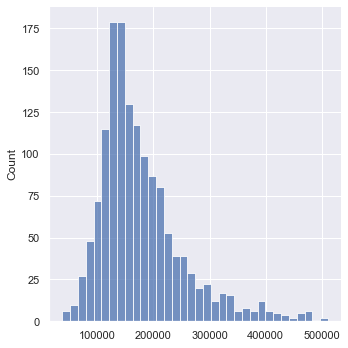

In [1332]:
submission = predict_blend(validation)
sns.displot( np.expm1(submission))

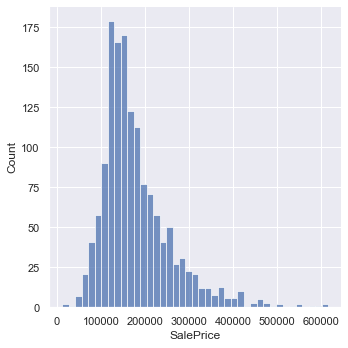

In [1333]:
sns.displot(cheat["SalePrice"])

In [1334]:
d = {'Id': val_ids.to_numpy(), 'SalePrice':  np.expm1(submission)}
df = pd.DataFrame(data=d)
df

,Id,SalePrice
0,1461,135123.684761
1,1462,165513.556057
2,1463,193636.760153
3,1464,196256.648382
4,1465,182042.473585
...,...,...
1454,2915,80384.217252
1455,2916,79210.040866
1456,2917,162778.084164
1457,2918,113112.571090


In [1335]:
df.to_csv('submission.csv', index=False)

RMSLE: 0.1333949585272273


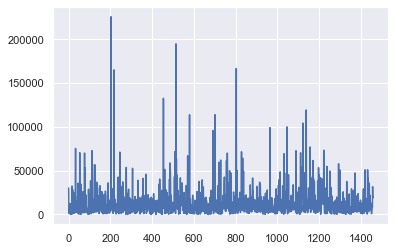

In [1336]:
print("RMSLE: " + str(rmsle(submission, np.log1p(cheat["SalePrice"]))))

plt.plot(np.abs(cheat["SalePrice"].to_numpy() - df["SalePrice"].to_numpy()))
plt.show()